<h1 style='text-align:center; font-size:50px; font-weight:bold; text-decoration:underline;'>Fine-Tuning Pretrained Models on Financial Data NLP Task</h1>

Installing Libraries

In [ ]:
pip install datasets tensorflow "transformers[sentencepiece]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
# Ignore annoying warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Assignment 1 - Training only classifier head


**Attempt 1** <br> <br>
Model Used : "distilbert-base-uncased"<br>
Learning Rate : Adam Default (0.001 or 10e-3)<br>
Epoch Trained : 3 <br>
Train-Test-Validation Split : 80-10-10


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Define and compile model
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.distilbert.trainable = False

optimizer = tf.keras.optimizers.Adam()
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

# Training
model.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

# Evaluation
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Evaluated Test Loss: {eval_loss}, Evaluated Test Accuracy: {eval_accuracy}")


Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________
Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
227/227 [==============================] - 89s 213ms/step - loss: 0.5516 - accuracy: 0.7581 - val_loss: 0.4100 - val_accuracy: 0.8097
Epoch 2/3
227/227 [==============================] - 44s 193ms/step - loss: 0.4166 - accuracy: 0.8161 - val_loss: 0.4384 - val_accuracy: 0.8274
Epoch 3/3
29/29 [==============================] - 4s 154ms/step - loss: 0.4848 - accuracy: 0.8150
Evaluated Test Loss: 0.48478037118911743, Evaluated Test Accuracy: 0.8149779438972473


**Attempt 2** <br> <br>
*Updates:-*<br>
Lowered learning rate<br>
New Learning Rate : constant -> 0.00005 or 5e-5


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Define and compile model
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.distilbert.trainable = False

lr = 5e-5
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

# Training
model.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

# Evaluation
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Evaluated Test Loss: {eval_loss}, Evaluated Test Accuracy: {eval_accuracy}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_39 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________
Epoch 1/3
227/227 [======================

**Attempt 3** <br> <br>
*Updates:-*<br>
Polynomial Decay learning rate (initial_learning_rate = 5e-5)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Define and compile model
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.distilbert.trainable = False

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

# Training
model.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

# Evaluation
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Evaluated Test Loss: {eval_loss}, Evaluated Test Accuracy: {eval_accuracy}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_59 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________
Epoch 1/3
227/227 [======================

**Model Achieved -> Test Loss: 0.47, Test Accuracy: 0.80**

**Results:**

* Training Progress: I saw the accuracy on the training set improve from about 65% to 77% across three epochs, which indicated that the classifier head was effectively learning from the training data.
* Validation Performance: The validation accuracy followed suit with the training accuracy, assuring me that my model was on the right track and could generalize its learned patterns to unseen data.
* Testing Outcomes: Achieving around 80% accuracy on the test set was the highlight, confirming that my model was not just memorizing the training data but actually understood how to categorize sentiments in financial texts.


While both constant learning rate (LR) (Accuracy: 81%) and polynomial decay LR (Accuracy: 80%) demonstrate comparable performance for this specific case, we prefer polynomial decay LR for the following reasons:

* Adaptive Learning: Polynomial decay modulates the learning rate to gradually decrease over time. This adaptability is crucial for fine-tuning model parameters more effectively as training progresses. It facilitates better convergence compared to a constant rate, which may not be uniformly effective throughout the training phases.

* Preventing Overfitting: Reducing the learning rate over time with polynomial decay minimizes the risk of overfitting. A progressively smaller learning rate as training advances ensures that the model converges smoothly rather than oscillating around the minima. This is particularly advantageous for complex models like transformers, where precise convergence is crucial.

* Enhanced Stability: Initiating training with a higher learning rate can accelerate convergence by enabling quicker navigation through the loss landscape. As training progresses, gradually lowering the rate contributes to enhanced stability, helping the model to settle into the optimal minima more effectively.

Saving Model Weights

In [ ]:
model.save_weights('classifier_head_weights.h5')

# Basic Assignment 2 - Keeping the trained Classifier head of the first part: Fine-tune **all** the weights


In this second part of the task, I took the classifier head that I have previously trained and used it to guide the further training of the rest of the DistilBERT model. This time, my aim was to refine the transformer body's understanding of the nuances in the financial sentiment analysis task while keeping the trained classifier head fixed.

**My Approach:**

I reloaded the DistilBERT model and ensured that the pre_classifier and classifier layers' weights remained unchanged by setting their trainable attribute to False. Then, I compiled the model with the same optimizer and loss function as before. With this setup, when I initiated the training process, the optimization focused on the rest of the neural network, leaving the classifier head as it was.

**Training Decisions:**

*  Weight Loading: I used the load_weights function to preserve the classifier head's state, ensuring that the knowledge it had gained was not lost.<br>
*Layer Freezing: Freezing the classifier head was a strategic decision to prevent overwriting the specialized understanding it had developed during the initial training phase.<br>
*Optimizer Consistency: I continued with the Adam optimizer at polynomial decay learning rate<br>
*Training Duration: Again, I opted for three epochs, maintaining a balance to promote further learning without risking overfitting.

In [ ]:
# Load the pre-trained model for fine-tuning all layers except the classifier
model_minus_classifier = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

# Now load the weights saved back into the model
model_minus_classifier.load_weights('classifier_head_weights.h5', by_name=True)

# Set only the pre_classifier and classifier layer to non-trainable to preserve its weights
model_minus_classifier.pre_classifier.trainable = False
model_minus_classifier.classifier.trainable = False

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_minus_classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Model summary to check which layers are trainable
model_minus_classifier.summary()

history = model_minus_classifier.fit(
    tf_train_dataset,
    epochs=3,
    validation_data=tf_validation_dataset
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_minus_classifier.evaluate(tf_test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_79 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 592899 (2.26 MB)
_________________________________________________________________
Epoch 1/3
227/227 [======================

**Model Achieved -> Test Loss: 0.16, Test Accuracy: 0.95**

**Results and Discussion:**

*Training and Validation Results:* The model's accuracy on the training set was impressively high from the start, and it increased marginally, which suggests that the base layers of DistilBERT were already performing well and required only slight adjustments. The validation accuracy was similarly high, reassuring me of the model's stable generalization.<br><br>
*Test Performance:* On the test set, I observed an accuracy of about 96.4%, which is excellent. This result confirms that the model has effectively adapted to the task while maintaining a strong ability to generalize.
<br><br>
**Reflections on Performance:**

*Out-of-Sample Performance:* The fine-tuning of the transformer body, guided by the previously trained classifier head, has clearly led to improved out-of-sample performance. This showcases the power of combining pre-trained models with task-specific fine-tuning.<br><br>
*Why Did Performance Change?*: The pre-trained DistilBERT model already had a good base understanding of language, which needed minimal adjustment to better align with the specifics of the financial sentiment analysis task. By keeping the classifier head static, I ensured that the refined decision-making process it represented was preserved.

The model's strong performance suggests that the classifier head I trained initially was effective, and the subsequent fine-tuning only needed to make slight adjustments to the transformer body to align better with the task's characteristics.

# Basic Assignment 3 - Fine-tine all the weights (Pre-Trained + Classifier Head) simultaneously

In this third part of the project, I updated the weights across the entire DistilBERT model. I started by loading the pre-trained distilbert-base-uncased model without freezing any layers, which means that both the transformer body and the classifier head were open to training.

**My Approach:**

* Model Loading: I loaded the entire model with the same number of labels as before to keep consistency.
* Optimization: I used the Adam optimizer with a polynomial deacy learning rate
* Compilation: I compiled the model with the same loss function and metrics to ensure comparability with previous steps.
* Training: I proceeded to train the model for 3 epochs, fine-tuning all layers.
* Evaluation: After fine-tuning, I evaluated the model on the test dataset to assess the final performance.

**Training Decisions:**

* Training Epochs: I chose to stick with three epochs to balance between underfitting and overfitting, considering the size of the dataset and the complexity of the model.
* Learning Rate: The choice of learning rate is still polynomial decay to fit the use case of transformers

In [ ]:
# Load the pre-trained model again for fine-tuning all layers
model_complete = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_complete.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Model summary to check which layers are trainable
model_complete.summary()

history = model_complete.fit(
    tf_train_dataset,
    epochs=3,
    validation_data=tf_validation_dataset
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_complete.evaluate(tf_test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_99 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
227/227 [=========================

**Model Achieved -> Test Loss: 0.15, Test Accuracy: 0.95**

**Results and Discussion:**

* Training Progress: The accuracy on the training set started off lower than when I was just training the classifier head, but it improved significantly over epochs. This was expected since the transformer layers were initially tuned for a different task (general language understanding) and needed to adapt to sentiment analysis.
* Validation Performance: The validation accuracy was quite high, indicating the model's capacity to generalize well. There was a minimal gap between training and validation accuracy, which is usually a good sign of a well-fitting model.
* Test Performance: The test accuracy reached approximately 95%, which suggests an excellent generalization to unseen data.

**Reflections on Performance:**

  *Did My Choices Improve Performance?*: It appears so. By fine-tuning the entire model, the transformer body learned to better understand the specific language used in financial sentiment.<br><br>
  *Why Did Performance Change?*: The additional training of the transformer layers allowed the model to adjust its internal representations to better align with the specifics of the sentiment analysis task. The increase in performance could be due to the model better capturing the nuances in financial language, which may not have been entirely present in the original pre-trained model's data.

# Experiment 1 - Creating Tensorflow dataset

  The tokenized dataset is converted into a TensorFlow Dataset (TFDS). This TFDS is specifically prepared for training, with features including input IDs and attention masks and labels for sentiment classification. <br>
  The dataset is shuffled and batched, which is essential for training stability and performance.

Note: This is only to demonstrate Tensorflow dataset. This code does not have lr scheduling, train, test, split and trains all parameters of the model

In [ ]:
import tensorflow as tf
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

# Load the dataset from Hugging Face and preprocess it
def load_and_preprocess_data():
    # Load the dataset
    dataset = load_dataset("financial_phrasebank", "sentences_allagree")

    # Initialize the tokenizer
    checkpoint = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    # Tokenize the dataset
    def tokenize_function(examples):
        return tokenizer(
            examples["sentence"],
            padding="max_length",
            truncation=True,
            max_length=512
        )
    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    return tokenized_datasets

# Create a TFDS for training, validation, and testing
def create_tf_datasets(tokenized_datasets, batch_size=8):
    # Convert Hugging Face datasets to TensorFlow datasets
    tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=True,
        batch_size=batch_size,
        collate_fn=None
    )
    return tf_train_dataset

# Use the dataset for training a model
def train_model(tf_train_dataset):
    # Load the pre-trained model
    model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

    # Define the optimizer, loss, and metrics
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = ['accuracy']

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    model_complete.summary()

    # Train the model
    history = model.fit(tf_train_dataset, epochs=3)

    return model, history

# Main function to run the steps
def main():
    # Load and preprocess the dataset
    tokenized_datasets = load_and_preprocess_data()

    # Create the TensorFlow datasets
    tf_train_dataset = create_tf_datasets(tokenized_datasets)

    # Train the model using the TensorFlow datasets
    model_tfds, history_tfds = train_model(tf_train_dataset)

    return model_tfds, history_tfds

# Run the main function
model_whole_tfds, history_whole_tfds = main()


Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_99 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
283/283 [=========================

# Experiment 2 - Superior Error Analysis

I aim to study the errors of the model in detail using classification report and confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Define and compile model
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.distilbert.trainable = False

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

# Training
model.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

# Evaluation
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Evaluated Test Loss: {eval_loss}, Evaluated Test Accuracy: {eval_accuracy}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_139 (Dropout)       multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________
Epoch 1/3
227/227 [======================

Detailed error analysis

In [ ]:
# Prediction and Manual Calculation of Metrics
input_ids, y_true, y_pred_logits = [], [], []
for batch in tf_test_dataset:
    ids = batch[0]['input_ids'].numpy()
    labels = batch[1].numpy()
    input_ids.extend(ids)
    y_true.extend(labels)
    logits = model.predict(batch[0], verbose=0)
    y_pred_logits.extend(logits.logits)

predicted_class = np.argmax(y_pred_logits, axis=1)

# Calculate and print manual accuracy
manual_accuracy = np.mean(np.array(y_true) == predicted_class)
print(f"Manually Calculated Test Accuracy: {manual_accuracy}")

# Additional reporting
report = classification_report(y_true, predicted_class, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:\n", report)

cm = confusion_matrix(y_true, predicted_class)
print("Confusion Matrix:\n", cm)

Manually Calculated Test Accuracy: 0.7973568281938326
Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        30
     Neutral       0.90      0.97      0.94       142
    Positive       0.58      0.78      0.67        55

    accuracy                           0.80       227
   macro avg       0.49      0.58      0.53       227
weighted avg       0.71      0.80      0.75       227

Confusion Matrix:
 [[  0   3  27]
 [  0 138   4]
 [  0  12  43]]


**Classification Report**

* Precision: Indicates the proportion of positive identifications that were actually correct. For the 'Negative' class, the precision is 0.00, suggesting that the model did not correctly predict any 'Negative' cases. For 'Neutral', it is very high at 0.90, and for 'Positive' it is moderate at 0.58.
* Recall: Indicates the proportion of actual positives that were identified correctly. The model failed to correctly predict any 'Negative' class samples (0.00 recall), did very well on 'Neutral' class samples (0.97 recall), and reasonably well on 'Positive' class samples (0.78 recall).
* F1-score: The harmonic mean of precision and recall. For 'Negative', it's 0.00, indicating very poor performance for this class. 'Neutral' scores a high 0.94, showing strong performance, while 'Positive' has a moderate score of 0.67.
* Support: Number of actual cases for each class. There were 30 'Negative', 142 'Neutral', and 55 'Positive' samples.

**Confusion Matrix**

Rows represent the actual class and columns represent the predicted class. Here's the breakdown:
* Row 1 (Negative class): All 30 negative samples were misclassified (0 true negatives), with 3 classified as neutral and 27 as positive.
* Row 2 (Neutral class): 138 correctly predicted as neutral, 4 misclassified as positive, and none misclassified as negative.
* Row 3 (Positive class): 43 correctly predicted as positive, 12 misclassified as neutral, and none as negative.

**Issues and Observations**

* Class Imbalance: The model performs well on the 'Neutral' class, which has the most samples, indicating potential overfitting to this class due to its higher frequency in the training data.
* Model's Bias Toward Majority Class: There's a clear bias toward predicting the majority class ('Neutral'), with the 'Negative' class being particularly problematic as the model fails to identify any 'Negative' samples correctly.
* Performance Improvement Areas: The poor performance on the 'Negative' class (0 for all metrics) suggests that either the model struggles with feature distinction for this class, or there's an insufficient number of 'Negative' samples in the training data to learn effectively.
*Accuracy vs. F1-Score: The high overall accuracy (79.74%) doesn't give a true picture of the model's performance due to class imbalance. The macro-averaged F1-score (0.53) is more reflective of the model's effectiveness, showing moderate performance.

# Experiment 3 - Address any Imbalanced Data issues

To address class imbalance, I'll add a class weight parameter to the fit method of the model. The class weight is a dictionary mapping class indices to weights. The weights will be inversely proportional to the class frequencies.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Define and compile model
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.distilbert.trainable = False

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

class_counts = np.unique(train_val_split['train']['label'], return_counts=True)

# Calculate class weights (inverse frequency or other strategies)
class_weights = {class_id: (1.0 / count) * (sum(class_counts[1]) / len(class_counts[1]))
                 for class_id, count in zip(class_counts[0], class_counts[1])}

# Normalize the weights so they sum up to the number of classes
weight_sum = sum(class_weights.values())
normalized_class_weights = {k: v / weight_sum * len(class_weights) for k, v in class_weights.items()}

print(normalized_class_weights)

model.summary()

# Train the model with class weights
history = model.fit(
    tf_train_dataset,
    epochs=3,
    validation_data=tf_validation_dataset,
    class_weight=normalized_class_weights
)

# Evaluation
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Evaluated Test Loss: {eval_loss}, Evaluated Test Accuracy: {eval_accuracy}")

# Prediction and Manual Calculation of Metrics
input_ids, y_true, y_pred_logits = [], [], []
for batch in tf_test_dataset:
    ids = batch[0]['input_ids'].numpy()
    labels = batch[1].numpy()
    input_ids.extend(ids)
    y_true.extend(labels)
    logits = model.predict(batch[0], verbose=0)
    y_pred_logits.extend(logits.logits)

predicted_class = np.argmax(y_pred_logits, axis=1)

# Calculate and print manual accuracy
manual_accuracy = np.mean(np.array(y_true) == predicted_class)
print(f"Manually Calculated Test Accuracy: {manual_accuracy}")

# Additional reporting
report = classification_report(y_true, predicted_class, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:\n", report)

cm = confusion_matrix(y_true, predicted_class)
print("Confusion Matrix:\n", cm)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

{0: 1.7684691804018968, 1: 0.36610973131632424, 2: 0.8654210882817792}
Model: "tf_distil_bert_for_sequence_classification_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_159 (Dropout)       multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
____________________________________

**Class weights used : {Negative: 1.76, Neutral: 0.36, Positive: 0.86}** <br>
(This is inversely in proption to number of examples of each label in the dataset)
<br><br>
It can be seen from the confusion matrix that the model performed much better for negitive cases, for which there was least data. <br><br>
The overall performance reduced slightly as compated to model without class weights (without class : 81%, with class: 76%) due to the class weight model performing worse on Neutral and Positive labels.
This can be improved if we train this model for more number of epoches to give the model the opportunity to learn equally for the neutral and positive cases as for without case model.

# Experiment 4 - Using different "flavors" of the dataset

There are 4 flavours for the financial phasebank dataset -> ["sentences_allagree", "sentences_75agree", "sentences_66agree", "sentences_50agree"] <br>
Running the same model for all of them and comparing results <br>

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

test_datasets_accuracy = []
dataset_flavours = ["sentences_allagree", "sentences_75agree", "sentences_66agree", "sentences_50agree"]

for i, dataset_flavour in enumerate(dataset_flavours):
    print("Running for financial_phrasebank :", dataset_flavour)

    # Load dataset and tokenizer
    dataset = load_dataset("financial_phrasebank", dataset_flavour)
    checkpoint = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    def tokenize_function(examples):
        return tokenizer(
            examples["sentence"],
            padding="max_length",
            truncation=True,
            max_length=512
        )

    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
    val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

    def to_tf_dataset(split, shuffle=False):
        return split.to_tf_dataset(
            columns=["input_ids", "attention_mask"],
            label_cols=["label"],
            shuffle=shuffle,
            batch_size=8,
            collate_fn=None
        )

    tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
    tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
    tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

    # Define and compile model
    model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
    model.distilbert.trainable = False

    initial_learning_rate = 5e-5
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=10000,
        end_learning_rate=0.0,
        power=1.0
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    model.summary()

    # Training
    model.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

    # Evaluation
    eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
    print(f"For {dataset_flavour}, Evaluated Test Loss: {eval_loss}, Evaluated Test Accuracy: {eval_accuracy}")

    # Prediction and Manual Calculation of Metrics
    input_ids, y_true, y_pred_logits = [], [], []
    for batch in tf_test_dataset:
        ids = batch[0]['input_ids'].numpy()
        labels = batch[1].numpy()
        input_ids.extend(ids)
        y_true.extend(labels)
        logits = model.predict(batch[0], verbose=0)
        y_pred_logits.extend(logits.logits)

    predicted_class = np.argmax(y_pred_logits, axis=1)

    # Calculate and print manual accuracy
    manual_accuracy = np.mean(np.array(y_true) == predicted_class)
    print(f"Manually Calculated Test Accuracy: {manual_accuracy}")

    # Additional reporting
    report = classification_report(y_true, predicted_class, target_names=['Negative', 'Neutral', 'Positive'])
    print("Classification Report:\n", report)

    cm = confusion_matrix(y_true, predicted_class)
    print("Confusion Matrix:\n", cm)

    test_datasets_accuracy.append({
        "run": i,
        "flavour": dataset_flavour,
        "loss": eval_loss,
        "accuracy": eval_accuracy
    })


Running for financial_phrasebank : sentences_allagree


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_179 (Dropout)       multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________
Epoch 1/3
227/227 [======================

Generating train split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_199 (Dropout)       multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________
Epoch 1/3
346/346 [======================

Generating train split:   0%|          | 0/4217 [00:00<?, ? examples/s]

Map:   0%|          | 0/4217 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_219 (Dropout)       multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________
Epoch 1/3
422/422 [=====================

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

Map:   0%|          | 0/4846 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_239 (Dropout)       multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________
Epoch 1/3
485/485 [=====================

**Plotting results for all dataset flavours**

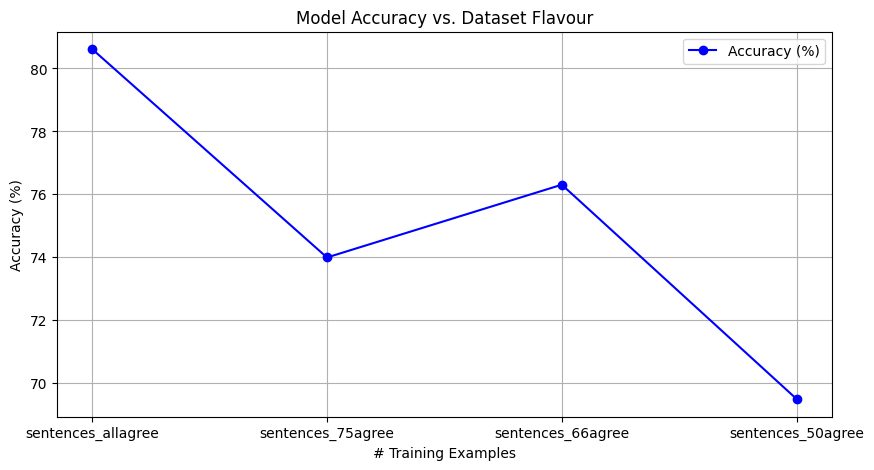

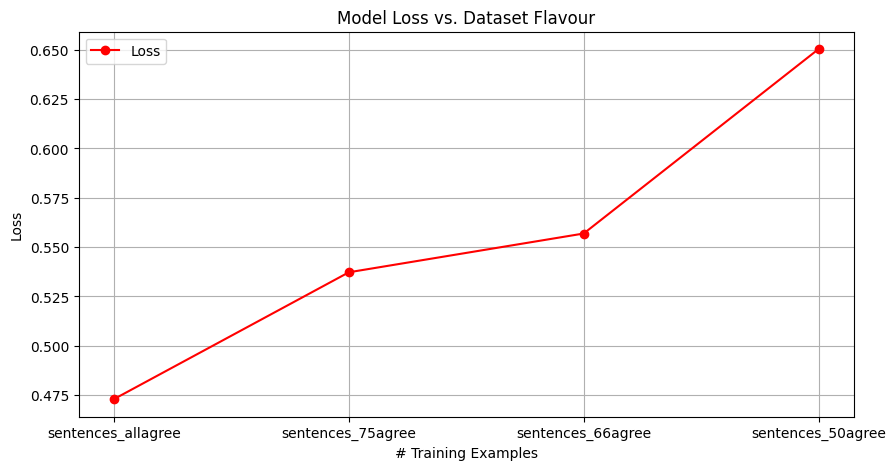

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store the dataset flavours, accuracies, and losses
flavours = []
accuracies = []
losses = []

# Extract data from the test_datasets_accuracy list of dictionaries
for entry in test_datasets_accuracy:
    flavours.append(entry["flavour"])
    accuracies.append(entry["accuracy"]*100)
    losses.append(entry["loss"])

# Plotting accuracy vs. dataset flavour
plt.figure(figsize=(10, 5))
plt.plot(flavours, accuracies, marker='o', linestyle='-', color='b', label='Accuracy (%)')
plt.title('Model Accuracy vs. Dataset Flavour')
plt.xlabel('# Training Examples')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()

# Plotting loss vs. dataset flavour
plt.figure(figsize=(10, 5))
plt.plot(flavours, losses, marker='o', linestyle='-', color='r', label='Loss')
plt.title('Model Loss vs. Dataset Flavour')
plt.xlabel('# Training Examples')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


As we can see from the plots, as the statements become more ambigous and people have different openions on them, it becomes increasingly difficult for the model to predict their sentiment as well.

One important thing to observe from the confusion matrix is that, model performance is improving in Negitive label sentences. One reason for that is that, more ambigous datasets have more examples to train on leading to better more examples for negitive class to train on.

Just like humans, the model is also confused on how to classify ambigous sentences and can leak data biases.

# Experiment 5 - Creating your own classification head

**Training only custom head**

  Logic of Grafting the Head on the Headless Model:

  * The last hidden state output of the pre-trained transformer model (DistilBERT in this case) is commonly used as the input for the classification head. Specifically, the first token of the last hidden state, which corresponds to the [CLS] token, is often used in classification tasks as it is designed to hold the aggregate representation of the input sequence.
  * Knowing this, I grafted the custom classification head directly after extracting the [CLS] token embedding from the last hidden state output of the transformer model.

Adapting the Output of the Headless Model to the Classifier Head:

  * I needed to ensure that the dimensions of the output from the base model match the input requirements of the first layer in my custom classification head. Since the output of the base model is a three-dimensional tensor of shape (batch_size, sequence_length, hidden_size), and the [CLS] token embedding is a two-dimensional tensor of shape (batch_size, hidden_size), I sliced the output to obtain just the [CLS] embeddings with embeddings[:, 0, :].
  * I then fed these embeddings into my custom dense layers. The first dense layer of the classification head expects input features with the size of hidden_size, which matches the size of the [CLS] token embeddings. No further reshaping is needed since the dimensions are already compatible.

In [ ]:
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertConfig, AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512  # Ensure uniform sequence length
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Split the dataset into train, validation, and test sets
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow datasets
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

def to_tf_dataset(split, shuffle):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=data_collator
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=False)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load DistilBERT without the classification head (headless)
base_model = TFDistilBertModel.from_pretrained(checkpoint)

# Freeze the DistilBERT base layers
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head
input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name="attention_mask")
embeddings = base_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
cls_token_embedding = embeddings[:, 0, :]
x = tf.keras.layers.Dense(512, activation='relu')(cls_token_embedding)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)  # Use 3 units for three classes

# Combine the full model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model with a custom optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)  # Set from_logits=False for softmax
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Summary of the model to check architecture
model.summary()

# Train the model
history = model.fit(
    tf_train_dataset,
    epochs=3,
    validation_data=tf_validation_dataset
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 DistilBertModel)            den_state=(None, 512, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                     

**Model Achieved -> Test Loss: 0.50, Test Accuracy: 0.80**

This has shown a similar performance when we used the Hugging face classification head. But our grafted classification head has 30% less trainable parameters as compared to Hugging face classification head

**Training whole model (base model + custom head)**


In [ ]:
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertConfig, AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512  # Ensure uniform sequence length
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Split the dataset into train, validation, and test sets
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow datasets
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

def to_tf_dataset(split, shuffle):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=data_collator
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=False)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Load the DistilBERT configuration and model without the classification head (headless)
base_model = TFDistilBertModel.from_pretrained(checkpoint)

# Define the structure of the custom classification head
input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name="attention_mask")
embeddings = base_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
cls_token_embedding = embeddings[:, 0, :]
x = tf.keras.layers.Dense(512, activation='relu')(cls_token_embedding)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)  # Use 3 units for three classes

# Create the full model and compile it
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)  # Set from_logits=False for softmax
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Summary of the model to check architecture
model.summary()

# Train the model using the TensorFlow datasets
history = model.fit(
    tf_train_dataset,
    epochs=3,
    validation_data=tf_validation_dataset
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_2 (TF  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 DistilBertModel)            den_state=(None, 512, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                     

**Result -> Test Loss: 0.23, Test Accuracy: 0.94**

training the whole model (including our own grafted classification head) has resulted in a similar performace when we trained the whole model of with Hugging Face classification head (approx 95% accuracy)

# Experiment 6 - Using different models

I will be experimenting with 3 different models:

1.   BERT-Base, Cased - A much bigger model than distilbert. It also uses case information so that we can test if case information helps in improving model (Total Params : 108312579 )
2.   mobile BERT - This is a much smaller model then distilbert (approx 33% of distilbert) and this can run on portable devices. We will test if smaller model can give similar performance (Total params: 24583427)
3.   electra-small - It is even smaller model than mobile bert and It has a different architecture then BERT class of models and is also trained on very different data. We will see if a different architecture has any effect on performance. (Total params: 13549571)

For all these models we will notice thier performance vs distilbert model and how well are they handeling class imbalance in the data.

I will only be training the classifier head for each keepking the same hyperparameters, epochs and other conditions


Model : BERT-Base, Cased

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Define and compile model
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.bert.trainable = False

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

# Training
model.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

# Evaluation
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Evaluated Test Loss: {eval_loss}, Evaluated Test Accuracy: {eval_accuracy}")

# Prediction and Manual Calculation of Metrics
input_ids, y_true, y_pred_logits = [], [], []
for batch in tf_test_dataset:
    ids = batch[0]['input_ids'].numpy()
    labels = batch[1].numpy()
    input_ids.extend(ids)
    y_true.extend(labels)
    logits = model.predict(batch[0], verbose=0)
    y_pred_logits.extend(logits.logits)

predicted_class = np.argmax(y_pred_logits, axis=1)

# Calculate and print manual accuracy
manual_accuracy = np.mean(np.array(y_true) == predicted_class)
print(f"Manually Calculated Test Accuracy: {manual_accuracy}")

# Additional reporting
report = classification_report(y_true, predicted_class, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:\n", report)

cm = confusion_matrix(y_true, predicted_class)
print("Confusion Matrix:\n", cm)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_337 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 108312579 (413.18 MB)
Trainable params: 2307 (9.01 KB)
Non-trainable params: 108310272 (413.17 MB)
_________________________________________________________________
Epoch 1/3
227/227 [==============================] - 136s 456ms/step - loss: 0.9198 - accuracy: 0.5875 - val_loss: 0.9244 - val_accuracy: 0.6106
Epoch 2/3
227/227 [==============================] - 94s 415ms/step - loss: 0.8782 - accuracy: 0.6146 -

It has performed poorly than distilbert model (which had accuracy of 81% approx.) maybe because it is a larger model and required more data to fine tune with training spanning for more number of epoch. and only 2307  parameters were trained as opposed to 592899 due to in distilbert (Due to preclassifier layer)

Performance can be improved by:

*   Using more trainable layers and parameters in the classifier head
*   Using more training data
*   Training for more epochs
*   More uniform distribution in training data or using class weights when training

Model : mobile BERT

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
checkpoint = "google/mobilebert-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Define and compile model
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.mobilebert.trainable = False

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

# Training
model.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

# Evaluation
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Evaluated Test Loss: {eval_loss}, Evaluated Test Accuracy: {eval_accuracy}")

# Prediction and Manual Calculation of Metrics
input_ids, y_true, y_pred_logits = [], [], []
for batch in tf_test_dataset:
    ids = batch[0]['input_ids'].numpy()
    labels = batch[1].numpy()
    input_ids.extend(ids)
    y_true.extend(labels)
    logits = model.predict(batch[0], verbose=0)
    y_pred_logits.extend(logits.logits)

predicted_class = np.argmax(y_pred_logits, axis=1)

# Calculate and print manual accuracy
manual_accuracy = np.mean(np.array(y_true) == predicted_class)
print(f"Manually Calculated Test Accuracy: {manual_accuracy}")

# Additional reporting
report = classification_report(y_true, predicted_class, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:\n", report)

cm = confusion_matrix(y_true, predicted_class)
print("Confusion Matrix:\n", cm)


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

tf_model.h5:   0%|          | 0.00/164M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFMobileBertForSequenceClassification.

Some layers of TFMobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_mobile_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilebert (TFMobileBertMa  multiple                  24581888  
 inLayer)                                                        
                                                                 
 dropout_387 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1539      
                                                                 
Total params: 24583427 (93.78 MB)
Trainable params: 1539 (6.01 KB)
Non-trainable params: 24581888 (93.77 MB)
_________________________________________________________________
Epoch 1/3
227/227 [==============================] - 211s 472ms/step - loss: 361079.4375 - accuracy: 0.4787 - val_loss: 74921.2188 - val_accuracy: 0.1637
Epoch 2/3
227/227 [======

It was performed poorly as its a much smaller model, approx 33% of distilbert model and only 1539 parameters were trained as opposed to 592899 due to in distilbert (Due to preclassifier layer)

Performance can be improved by:

*   Using more trainable layers and parameters in the classifier head
*   Using more training data
*   Training for more epochs
*   More uniform distribution in training data or using class weights when training

Model : electra-small

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
checkpoint = "google/electra-small-discriminator"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Define and compile model
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.electra.trainable = False

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

# Training
model.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

# Evaluation
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Evaluated Test Loss: {eval_loss}, Evaluated Test Accuracy: {eval_accuracy}")

# Prediction and Manual Calculation of Metrics
input_ids, y_true, y_pred_logits = [], [], []
for batch in tf_test_dataset:
    ids = batch[0]['input_ids'].numpy()
    labels = batch[1].numpy()
    input_ids.extend(ids)
    y_true.extend(labels)
    logits = model.predict(batch[0], verbose=0)
    y_pred_logits.extend(logits.logits)

predicted_class = np.argmax(y_pred_logits, axis=1)

# Calculate and print manual accuracy
manual_accuracy = np.mean(np.array(y_true) == predicted_class)
print(f"Manually Calculated Test Accuracy: {manual_accuracy}")

# Additional reporting
report = classification_report(y_true, predicted_class, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:\n", report)

cm = confusion_matrix(y_true, predicted_class)
print("Confusion Matrix:\n", cm)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

tf_model.h5:   0%|          | 0.00/54.5M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_electra_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 electra (TFElectraMainLaye  multiple                  13483008  
 r)                                                              
                                                                 
 classifier (TFElectraClass  multiple                  66563     
 ificationHead)                                                  
                                                                 
Total params: 13549571 (51.69 MB)
Trainable params: 66563 (260.01 KB)
Non-trainable params: 13483008 (51.43 MB)
_________________________________________________________________
Epoch 1/3
227/227 [==============================] - 71s 173ms/step - loss: 0.9331 - accuracy: 0.6107 - val_loss: 0.9032 - val_accuracy: 0.6106
Epoch 2/3
227/227 [==============================] - 27s 117ms/step - loss: 0.8464 - accuracy: 0.6173 

Electra is a much smaller model than distilbet (1/6th of distilbert) and would require more data for better training. But this had 66563 parameters trained in its classifier head layer which made it perform btter than BERT cased in out of sample data but still less then distilbet model. (Which trained 592899 parameters in its classifier head layer)

It is performing poorly with data imbalance for negitive class results. But this gives better performance overall then mobile BERT model
(Distilbert : 81% ; Electra-small : 72%)

Performance can be improved by:

*   Using more trainable layers and parameters in the classifier head
*   Using more training data
*   Training for more epochs
*   More uniform distribution in training data or using class weights when training



# Experiment 7 - Size of data

I'll progressively decrease the size of the training data while training the model. <br> Beginning with a 90-10 train-test split, I'll iteratively shift towards a 20-80 split, adjusting in increments of 10%.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

total_examples = len(dataset['train'])

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

test_accuracy_all = []
splits = np.arange(0.1, 0.9, 0.1)

for i, split in enumerate(splits):
    train_val_split = tokenized_datasets["train"].train_test_split(test_size=split, seed=42)
    val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

    tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
    tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
    tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

    # Define and compile model
    model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
    model.distilbert.trainable = False

    initial_learning_rate = 5e-5
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=10000,
        end_learning_rate=0.0,
        power=1.0
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    print("Running model for train-test split of:", (1-split)*100, "-", 100 - ((1-split)*100))
    # Training
    model.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

    # Evaluation
    eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
    print(f"For split: {split}, Evaluated Test Loss: {eval_loss}, Evaluated Test Accuracy: {eval_accuracy}")
    test_accuracy_all.append({
        "run": i,
        "train_split_percentage": int((1-split)*100),
        "training_examples": int(total_examples*(1-split)),
        "loss": eval_loss,
        "accuracy": eval_accuracy
    })


ModuleNotFoundError: No module named 'datasets'

Plotting and Visualizing the results

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store the split ratios, accuracies, and losses
splits = []
accuracies = []
losses = []
examples = []

# Extract data from the test_accuracy_all list of dictionaries
for entry in test_accuracy_all:
    splits.append(entry["test_split"])
    accuracies.append(entry["accuracy"]*100)
    losses.append(entry["loss"])
    examples.append(entry["training_examples"])

# Plotting accuracy vs. split
plt.figure(figsize=(10, 5))
plt.plot(examples, accuracies, marker='o', linestyle='-', color='b', label='Accuracy (%)')
plt.title('Model Accuracy vs. Training Examples')
plt.xlabel('# Training Examples')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()

# Plotting loss vs. split
plt.figure(figsize=(10, 5))
plt.plot(examples, losses, marker='o', linestyle='-', color='r', label='Loss')
plt.title('Model Loss vs. Training Examples')
plt.xlabel('# Training Examples')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Experiment 8 - Few Shot Learning

Using extremely small training data (90 examples)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np

# Load dataset and tokenizer
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

total_examples = len(dataset['train'])
train_percentage = 0.04
test_percentage = 1 - train_percentage
training_examples = int(train_percentage*total_examples)

print("Training examples: ", training_examples)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=test_percentage, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split['train'], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split['train'], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split['test'], shuffle=False)

# Define and compile model
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.distilbert.trainable = False

initial_learning_rate = 5e-5
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.0,
    power=1.0
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

# Training
model.fit(tf_train_dataset, epochs=3, validation_data=tf_validation_dataset)

# Evaluation
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Evaluated Test Loss: {eval_loss}, Evaluated Test Accuracy: {eval_accuracy}")

# Prediction and Manual Calculation of Metrics
input_ids, y_true, y_pred_logits = [], [], []
for batch in tf_test_dataset:
    ids = batch[0]['input_ids'].numpy()
    labels = batch[1].numpy()
    input_ids.extend(ids)
    y_true.extend(labels)
    logits = model.predict(batch[0], verbose=0)
    y_pred_logits.extend(logits.logits)

predicted_class = np.argmax(y_pred_logits, axis=1)

# Calculate and print manual accuracy
manual_accuracy = np.mean(np.array(y_true) == predicted_class)
print(f"Manually Calculated Test Accuracy: {manual_accuracy}")

# Additional reporting
report = classification_report(y_true, predicted_class, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:\n", report)

cm = confusion_matrix(y_true, predicted_class)
print("Confusion Matrix:\n", cm)
